# Introduction

Typically, hyper-parameter tuning is performed by doing a grid serach over the space of hyper-parameter values.

However, the space of hyper-parameter values can be large. 

Training multiple models over the range of hyper-parameter values can be time consuming even with parallelization. 

Randomized algorithms for hyper-parameter search exist and may provide satisfactory results at low computation cost, e.g. RandomizedSearchCV and HalvingRandomSerachCV in scikit-learn. Nevertheless, we can still miss out on a better configuration for the model.

Surrogate models allow optimal hyper-parameter search in a non-exhaustive way, guiding the search towards more promising candidates.

In this notebook, we train an XGBoost model to predict a model score associated to a hyper-parameter value. This way, we do not have to run a complete trining to calculate model score.

The general algorithm can be summarized as follows: n configurations are randomly drawn. The surrogate model performs a gain estimation for each one. the most promising configuration is then actually tested on the model to be trained. the gain obtained is reused to enrich the urrogate model.

As a case study, we apply the hyper-parameter model to the Boston dataset and compare results.

# Acknowledgment

This python notebook is an implementation of the Optimizer in Chapter 6 of "Practical Gradient Boosting" by Guillaume Saupin

# Configuration space and sampling

There are two prerequisites for finding an optimal hyper-parameter configuration:

    1) It is necessary to be able to describe this space of exploration.
    
    2) It is necessary to be able to sample configurations of this space.
    
The CongifSpace library in python makes this possible.

In [1]:
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformFloatHyperparameter, UniformIntegerHyperparameter

num_trees = UniformIntegerHyperparameter("num_trees", 10, 50, default_value = 10)

max_features = UniformIntegerHyperparameter("max_features", 1, 100, default_value = 1)

min_weight_frac_leaf =  UniformFloatHyperparameter("min_weight_frac_leaf", 0.0, 0.5, default_value = 0.0)

min_samples_to_split = UniformIntegerHyperparameter("min_samples_to_split", 2, 20, default_value = 2)

min_samples_in_leaf = UniformIntegerHyperparameter("min_samples_in_leaf", 1, 20, default_value = 1)

max_leaf_nodes = UniformIntegerHyperparameter("max_leaf_node", 10, 1000, default_value = 100)

It is also possible to add categorical parameters

In [2]:
do_bootstrapping = CategoricalHyperparameter("do_bootstrapping", ["true", "false"], default_value = "true")
criterion = CategoricalHyperparameter("criterion", ["mse", "mae"], default_value = "mse")

Finally, all these parameters can be grouped in a configuration space

In [3]:
cs = ConfigurationSpace()
cs.add_hyperparameters([num_trees, min_weight_frac_leaf, max_features, min_samples_to_split, min_samples_in_leaf,
                       max_leaf_nodes, criterion, do_bootstrapping])

[num_trees, Type: UniformInteger, Range: [10, 50], Default: 10,
 min_weight_frac_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0,
 max_features, Type: UniformInteger, Range: [1, 100], Default: 1,
 min_samples_to_split, Type: UniformInteger, Range: [2, 20], Default: 2,
 min_samples_in_leaf, Type: UniformInteger, Range: [1, 20], Default: 1,
 max_leaf_node, Type: UniformInteger, Range: [10, 1000], Default: 100,
 criterion, Type: Categorical, Choices: {mse, mae}, Default: mse,
 do_bootstrapping, Type: Categorical, Choices: {true, false}, Default: true]

The configutation space can be queried to provide a random configuration

In [4]:
cs.sample_configuration()

Configuration(values={
  'criterion': 'mae',
  'do_bootstrapping': 'true',
  'max_features': 32,
  'max_leaf_node': 130,
  'min_samples_in_leaf': 7,
  'min_samples_to_split': 10,
  'min_weight_frac_leaf': 0.373663668924116,
  'num_trees': 38,
})

# Optimizer

In [37]:
import pandas as pd
import numpy as np

class Optimizer:
    def __init__(self,
                algo_score,
                max_iter,
                max_intensification,
                model,
                cs):
        self.trajectory = []
        self.algo_score = algo_score
        self.max_iter = max_iter
        self.max_intensification = max_intensification
        self.internal_model = model()
        self.cfgs = []
        self.scores = {}
        self.best_cfg = None
        self.best_score = None
        self.cs = cs
        
    def cfg_to_dtf(self, cfgs):
        
        try:
            cfgs2 = [dict(cfg) for cfg in cfgs]
        except:
            print(cfg2)
            
        dtf = pd.DataFrame(cfgs2)
        
        return dtf
    
    def optimize(self):
        
        cfg = self.cs.sample_configuration()
        self.cfgs.append(cfg)
        self.trajectory.append(cfg)
        
        score = self.algo_score(cfg)
        self.scores[cfg] = score
        self.best_cfg = cfg
        self.best_score = score
        dtf = self.cfg_to_dtf(self.cfgs)
        
        for i in range(self.max_iter):
            
            if dtf.shape[0] > 1:
                
                scores = np.array([val for key, val in self.scores.items()])
                self.internal_model.fit(dtf, scores)
                
                candidates = [self.cs.sample_configuration() for i in range(self.max_intensification)]
                candidate_scores = self.internal_model.predict(self.cfg_to_dtf(candidates))
                
                best_candidates = np.argmax(candidate_scores)
                
                cfg = candidates[best_candidates]
                
            else:
                
                cfg = self.cs.sample_configuration()
                
            self.cfgs.append(cfg)
            score = self.algo_score(cfg)
            self.scores[cfg] = score
            
            if score > self.best_score:
                self.best_cfg = cfg
                self.best_score = score
                self.trajectory.append(cfg)
            
            dtf = self.cfg_to_dtf(self.cfgs)

# Case stude: California housing

In [39]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [40]:
def run(data, target, cfg):
    
    cfg_dict = {key:cfg[key] for key in cfg}
    
    rfr = RandomForestRegressor(**cfg_dict)
    
    def rmse(y, y_pred):
        return np.sqrt(np.mean(y_pred - y)**2)
    
    rmse_scorer = make_scorer(rmse, greater_is_better = False)
    score = cross_val_score(rfr, data, target, cv = 5, scoring=rmse_scorer, verbose = 0)
    score = np.mean(score)
    
    return score

In [41]:
num_trees = UniformIntegerHyperparameter("n_estimators", 10, 50, default_value = 10)

max_features = UniformIntegerHyperparameter("max_features", 1, 13, default_value = 1)

min_weight_frac_leaf =  UniformFloatHyperparameter("min_weight_fraction_leaf", 0.0, 0.5, default_value = 0.0)

min_samples_to_split = UniformIntegerHyperparameter("min_samples_split", 2, 20, default_value = 2)

min_samples_in_leaf = UniformIntegerHyperparameter("min_samples_leaf", 1, 20, default_value = 1)

max_leaf_nodes = UniformIntegerHyperparameter("max_leaf_nodes", 10, 1000, default_value = 100)

do_bootstrapping = CategoricalHyperparameter("bootstrap", [True, False], default_value = True)

criterion = CategoricalHyperparameter("criterion", ["friedman_mse", "absolute_error"], default_value = "friedman_mse")

In [42]:
cs = ConfigurationSpace()
cs.add_hyperparameters([num_trees, min_weight_frac_leaf, max_features, min_samples_to_split, min_samples_in_leaf,
                       max_leaf_nodes, criterion, do_bootstrapping])

[n_estimators, Type: UniformInteger, Range: [10, 50], Default: 10,
 min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0,
 max_features, Type: UniformInteger, Range: [1, 13], Default: 1,
 min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2,
 min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1,
 max_leaf_nodes, Type: UniformInteger, Range: [10, 1000], Default: 100,
 criterion, Type: Categorical, Choices: {friedman_mse, absolute_error}, Default: friedman_mse,
 bootstrap, Type: Categorical, Choices: {True, False}, Default: True]

In [43]:
housing = fetch_california_housing()
max_intensity = 25

In [ ]:
%%time
optimizer = Optimizer(lambda cfg: run(housing.data, housing.target, cfg), 50, 250,
                     lambda: CatBoostRegressor(cat_features = ["criterion", "bootstrap"]), cs)
optimizer.optimize()

## For XGBoost

In [45]:
cs = ConfigurationSpace()
cs.add_hyperparameters([num_trees, min_weight_frac_leaf, max_features, min_samples_to_split, min_samples_in_leaf, max_leaf_nodes])

[n_estimators, Type: UniformInteger, Range: [10, 50], Default: 10,
 min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0,
 max_features, Type: UniformInteger, Range: [1, 13], Default: 1,
 min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2,
 min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1,
 max_leaf_nodes, Type: UniformInteger, Range: [10, 1000], Default: 100]

In [46]:
%%time
optimizer_xgb = Optimizer(lambda cfg: run(housing.data, housing.target, cfg), 50, 250,
                         XGBRegressor, cs)
optimizer_xgb.optimize()

CPU times: total: 11min 18s
Wall time: 10min 13s


# Plotting the results

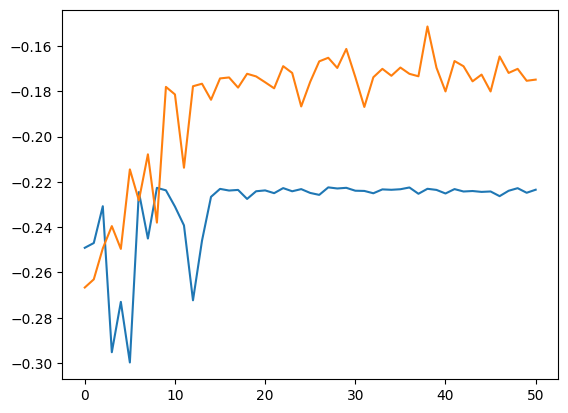

In [53]:
plt.plot(optimizer.scores.values())
plt.plot(optimizer_xgb.scores.values())